## Large Scale Optimization TP1:

#### Samuel Bazaz Jazayeri

In [5]:
pip install pywavelets

   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
    --------------------------------------- 0.1/4.3 MB 825.8 kB/s eta 0:00:06
   ---- ----------------------------------- 0.5/4.3 MB 4.7 MB/s eta 0:00:01
   -------------- ------------------------- 1.6/4.3 MB 10.0 MB/s eta 0:00:01
   -------------------------- ------------- 2.9/4.3 MB 14.0 MB/s eta 0:00:01
   ---------------------------------------  4.2/4.3 MB 17.0 MB/s eta 0:00:01
   ---------------------------------------- 4.3/4.3 MB 16.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install opencv-python

   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.2/38.1 MB 2.9 MB/s eta 0:00:13
   - -------------------------------------- 1.1/38.1 MB 9.8 MB/s eta 0:00:04
   -- ------------------------------------- 2.7/38.1 MB 17.2 MB/s eta 0:00:03
   ---- ----------------------------------- 4.2/38.1 MB 20.5 MB/s eta 0:00:02
   ------ --------------------------------- 5.7/38.1 MB 22.9 MB/s eta 0:00:02
   ------- -------------------------------- 7.3/38.1 MB 24.6 MB/s eta 0:00:02
   --------- ------------------------------ 9.0/38.1 MB 26.2 MB/s eta 0:00:02
   ----------- ---------------------------- 10.5/38.1 MB 34.6 MB/s eta 0:00:01
   ------------ --------------------------- 12.2/38.1 MB 34.4 MB/s eta 0:00:01
   -------------- ------------------------- 13.7/38.1 MB 32.7 MB/s eta 0:00:01
   --------------- ------------------------ 15.2/38.1 MB 34.4 MB/s eta 0:00:01


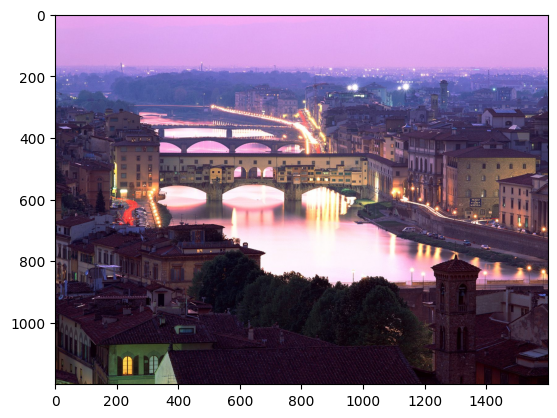

In [22]:
############
# Packages #
############
import cv2
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pywt
from pathlib import Path
from skimage import io

root_path = Path.cwd().parents[0]
sys.path.insert(0, str(root_path))

img_path = root_path.joinpath("image_denoizing", "florence.jpg")
x = io.imread(img_path)

plt.imshow(x)

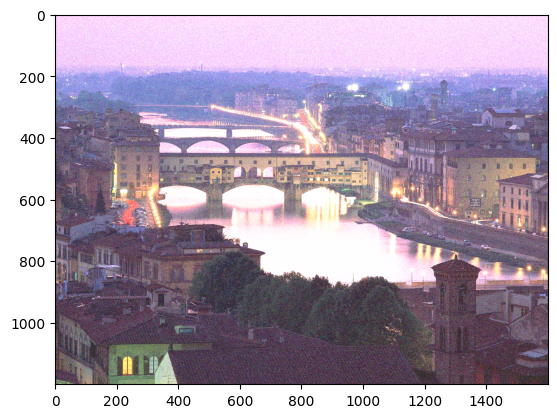

In [24]:
# Instantiate noise
shape = x.shape
noise = 100 * np.random.rand(shape[0], shape[1], shape[2])

# Add noise to the original image
y = x + noise

# Clip values
y = np.clip(y, 0, 255)

# Convert to 8 bits encoding
y = y.astype(np.uint8)
plt.imshow(y)

In [29]:
def display_wavelet_transform(img, max_level=3, title=None):
    """
    Display a 2D wavelet transformation on an input image
    
    Parameters
    ----------
    - img : numpy.ndarray
        Input image to be transformed
        
    - max_level : int (optional)
        Maximum number of level to display
        
    - title: str (optional)
        Title

    Returns
    ---------
    Display the 2D wavelet transformation
    
    
    Source
    ---------
    https://pywavelets.readthedocs.io/en/latest/ref/2d-decompositions-overview.html
    """
    shape = img.shape
    
    fig, axes = plt.subplots(1, max_level + 1, figsize=(14, 8))
    for level in range(0, max_level + 1):
        if level == 0:
            # Display original image
            axes[level].imshow(img)
            axes[level].set_title("Original image")
            axes[level].set_axis_off()
            continue
        
        # Compute 2D DWT
        coeffs = pywt.wavedec2(img.astype(float), "db2", 
                               mode="periodization", level=level, 
                               axes=(0, 1))
        
        # Normalize each coefficient array independently for better visibility
        coeffs[0] /= np.abs(coeffs[0]).max()
        for detail_level in range(level):
            coeffs[detail_level + 1] = [d / np.abs(d).max() for d in coeffs[detail_level + 1]]
        # Show the normalized coefficients
        arr, slices = pywt.coeffs_to_array(coeffs, axes=(0, 1))
        axes[level].imshow(arr)
        axes[level].set_title(f"Coefficients\n(level {level})")
        axes[level].set_axis_off()
        
    if title is not None:
        fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


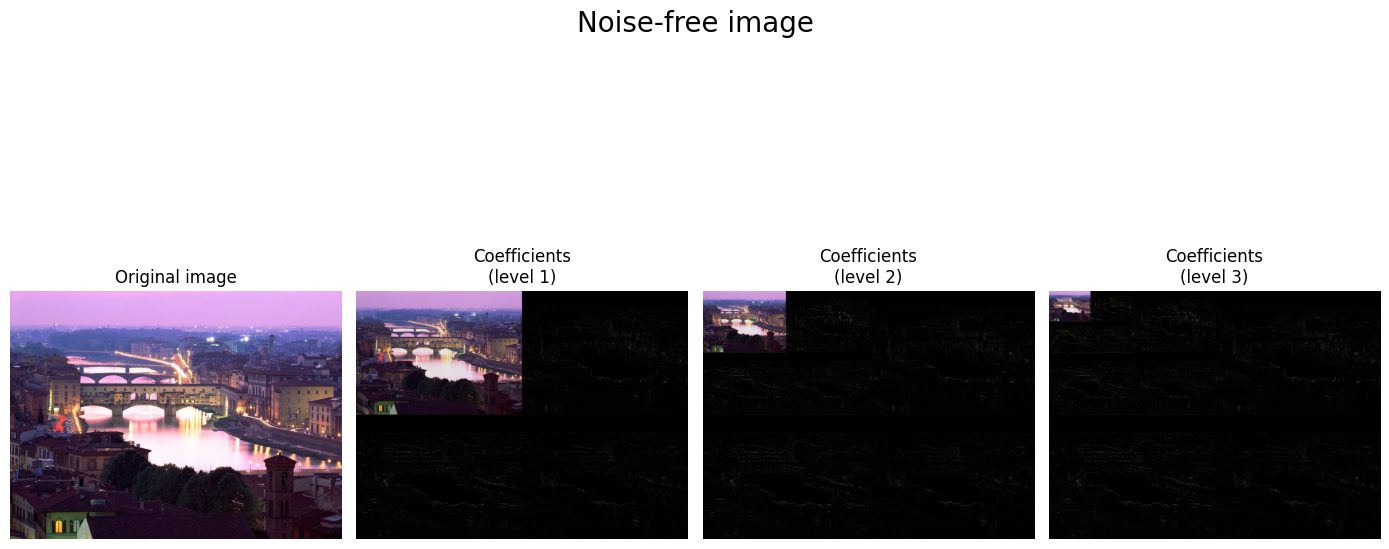

In [30]:
display_wavelet_transform(x, title="Noise-free image")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


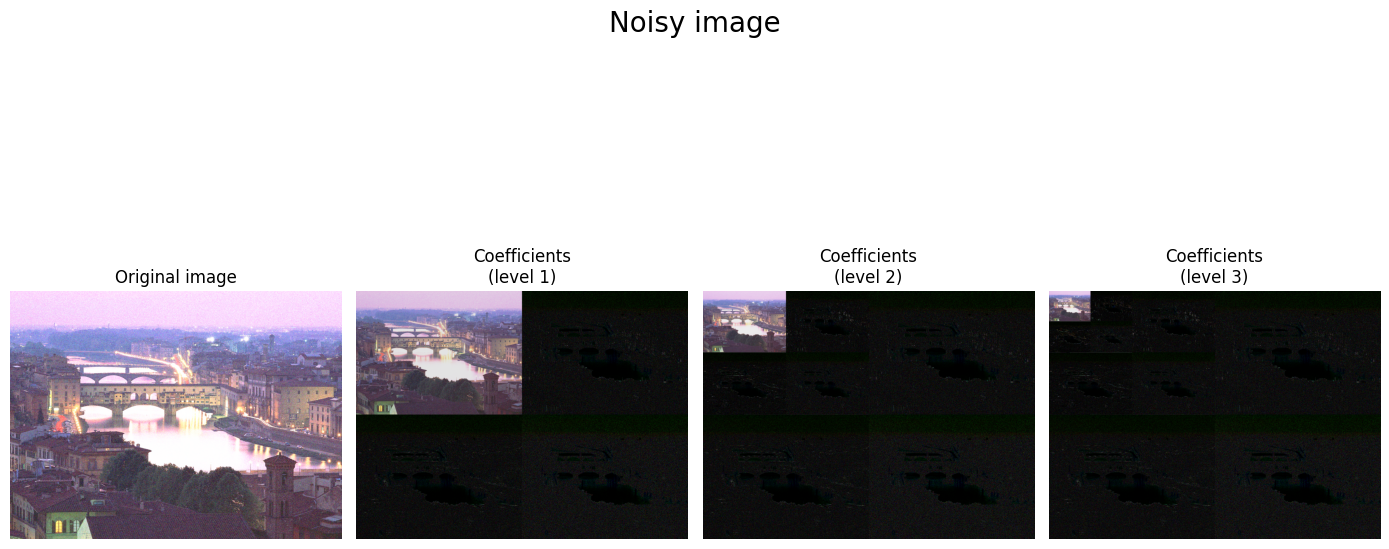

In [31]:

display_wavelet_transform(y, title="Noisy image")

Comment:

We observe that there are more non-null details coefficients in the noisy image than in the noise-free image. Our goal is precisely to penalize the details coefficients to recover a noise-free image from the noisy measurement, using primarily the 2D wavelet transform approximation coefficients.

In [32]:
def compute_mse(original, approx):
    """
    Compute the mean square error between
    a noise-free measurement and its approximation
    
    Parameters
    -------------
    - original : numpy.ndarray
        Original image encoded on 8 bits
        
    - approx : numpy.ndarray
        Approximate image encoded on 8 bits
        
    Returns
    -----------
    - mse : float
        Mean Square Error estimation
    """
    # Determine data types
    assert original.dtype == approx.dtype == "uint8",\
            "Expected 'uint8' dtype arrays"
    # Determine shape dimensions
    assert original.shape == approx.shape, "Misaligned shapes" 
    N = shape[0] * shape[1] * shape[2]    
    # Convert to float
    original = original.astype("float32")
    approx = approx.astype("float32")
    # Divide by 255
    original /= 255.
    approx /= 255.
    # Compute MSE
    mse = np.sum(original - approx)**2 / N
    return mse

In [33]:
def q_power_proximal(q, χ, ξ):
    """
    Compute the proximal of the power q function
    scaled to χ at point ξ
    
    Parameters
    ----------
    q : float
        Exponent in the power function
        Available: q = {1, 4/3, 3/2, 2, 3, 4}
        
    χ : float
        Regularization parameter
        
    ξ : float
        Point at which to compute the proximal operator
    
    Returns
    ---------
    prox : numpy.array
        Value of the proximal of the q power function
        at point ξ
    
    """
    Q_VALUES = [1.0, 4/3, 3/2, 2., 3., 4.]
    
    if q not in Q_VALUES:
        raise ValueError(f"q ({q}) does not belong in the expected "
                         f"values: {Q_VALUES}")
        
    prox = None
    
    if q == 1.0:
        prox = np.sign(ξ) * np.maximum(np.abs(ξ) - χ, 0)
    elif q == 4/3:
        ϵ = np.sqrt(ξ**2 + 256 / 729 * χ ** 3)
        prox = ξ + 4 * χ / (3 * 2 ** (1/3)) * ((ϵ - ξ) ** (1/3) - (ϵ + ξ) ** (1/3))
    elif q == 3/2:
        prox = ξ + 9 * χ ** 2 * np.sign(ξ) / 8 * (1 - np.sqrt(1 + 16 * np.abs(ξ) / (9 * χ ** 2)))
    elif q == 2:
        prox = ξ / (1 + 2 * χ)                    
    elif q == 3.:
        prox = np.sign(ξ) * (np.sqrt(1 + 12 * χ * np.abs(ξ)) - 1) / (6 * χ)
    elif q == 4.:
        ϵ = np.sqrt(ξ ** 2 + 1 / (27 * χ))
        prox = ((ϵ + ξ) / (8 * χ)) ** (1/3) - ((ϵ - ξ) / (8 * χ)) ** (1/3)
        
    return prox

Minimization using 2D discrete wavelet transform
In this section we minimize the optimization problem using a 2D discrete wavelet transform.

First, we compute the approximation and details coefficients.

Second, we apply the relevant proximal operator on the details coefficients only.

Third, we perform the inverse wavelet transform.

----------
Current settings:
decomposition levels: 3
q-power: 1
χ (regularization): 10
----------
MSE: 407.76025955047874


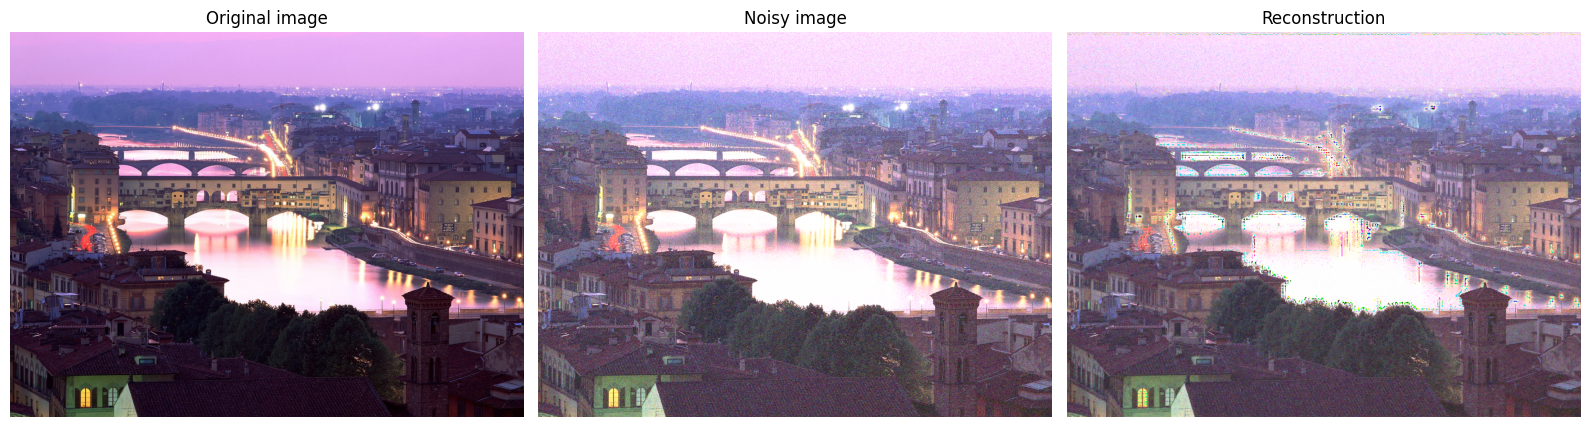

In [35]:
# Experiment setup
level = 3
q = 1
χ = 10

# Perform a 2D DWT
coeffs = pywt.wavedec2(y.astype(float), "db2", 
                               mode="periodization", level=level, 
                               axes=(0, 1))

# Apply the relevant proximal operator on the details coefficients
for l in range(level):
    coeffs[l + 1] = list(coeffs[l + 1]) # convert tuple (immutable) to list (mutable)
    for i in range(3):
        coeffs[l + 1][i] = q_power_proximal(q, χ, np.array(coeffs[l + 1][i]))

# Perform the 2D inverse DWT
z = pywt.waverec2(coeffs, "db2", mode="periodization", axes=(0, 1))

# Convert reconstruction to np.uint8
z = z.astype(np.uint8)

# Compute the MSE
mse = compute_mse(y, z)
print("-" * 10)
print("Current settings:")
print(f"decomposition levels: {level}")
print(f"q-power: {q}")
print(f"χ (regularization): {χ}")
print("-" * 10)
print(f"MSE: {mse}")


# Display reconstruction
fig, axes = plt.subplots(1, 3, figsize=(16, 10))
imgs = [x, y, z]
titles = ["Original image", "Noisy image", "Reconstruction"]
for i, tup in enumerate(zip(imgs, titles)):
    img, title = tup
    axes[i].imshow(img)
    axes[i].set_title(title)
    axes[i].set_axis_off()
plt.tight_layout()

Comment:

We see that the reconstruction is able to get rid of some noise, especially in the sky, where it becomes similar to the original image. However we notice the appearance of artifacts in the water below the main bridge. This highlights that the details are missing since they were corrupted by the noise that we removed. This phenomenon is striking on the light reflection in the water.

Hyper-parameters search
In this section we perform a hyper-parameters grid search to determine the set of parameters that best reconstruct the original image. Note that this is only possible since we have access to the original image, which is often not the case in practice.

We expect the 
 norm to perform better than other power 
 functions as it induces sparsity due to the soft thresholding. With that in mind, we store results from the 
 norm to be able to display them later on.

In [39]:
def minimization(y, q, level, χ):
    """
    Perform the optimization minimization on the noisy measurement
    
    Parameters
    ------------
    - y : numpy.ndarray (np.uint8)
        Noisy measurement
        
    q : float
        Exponent in the power function
        Available: q = {1, 4/3, 3/2, 2, 3, 4}
        
    level : int
        Decomposition level in Discrete Wavelet Transform
        
    χ : float
        Regularization parameter
    
    Returns
    -----------
    z : numpy.ndarray (np.uint8)
        Reconstruction result
    """
    # Perform a 2D DWT
    coeffs = pywt.wavedec2(y.astype(float), "db2", 
                                   mode="periodization", level=level, 
                                   axes=(0, 1))

    # Apply the relevant proximal operator on the details coefficients
    for l in range(level):
        coeffs[l + 1] = list(coeffs[l + 1]) # convert tuple (immutable) to list (mutable)
        for i in range(3):
            coeffs[l + 1][i] = q_power_proximal(q, χ, np.array(coeffs[l + 1][i]))

    # Perform the 2D inverse DWT
    z = pywt.waverec2(coeffs, "db2", mode="periodization", axes=(0, 1))

    # Convert reconstruction to np.uint8
    z = z.astype(np.uint8)
    
    return z

In [40]:
from itertools import product

In [41]:
%%time
# Hyper-parameters settings
Q_VALUES = [1.0, 4/3, 3/2, 2., 3., 4.]
LEVELS = [2, 3, 4, 5, 6, 7, 8]
χ_range = [10 ** (i) for i in range(-4, 3)]

best_q = None
best_level = None
best_χ = None
best_mse = np.inf
best_z = None

# Store some results to be displayed
l1_results = [list() for level in LEVELS]

# Perform a hyper-parameters search
settings = list(product(Q_VALUES, LEVELS, χ_range))
print(f"There are {len(settings)} settings being tested")
for i, tup in enumerate(settings):
    q, level, χ = tup
    z = minimization(y, q, level, χ)
    mse = compute_mse(y, z)
    if mse < best_mse:
        best_q = q
        best_level = level
        best_χ = χ
        best_mse = mse
        best_z = z
        
    if q == 1:
        l1_results[LEVELS.index(level)].append(mse)

There are 294 settings being tested
CPU times: total: 3min 19s
Wall time: 3min 20s


Contrarily to our belief, it appears that q=2 yields the best reconstruction, using the deepest Wavelet Transform level (level=8) and smallest regularization 
 (\chi=1e-4).

----------
Best settings:
decomposition levels: 8
q-power: 2.0
χ (regularization): 0.0001
----------
MSE: 21.16757001286149


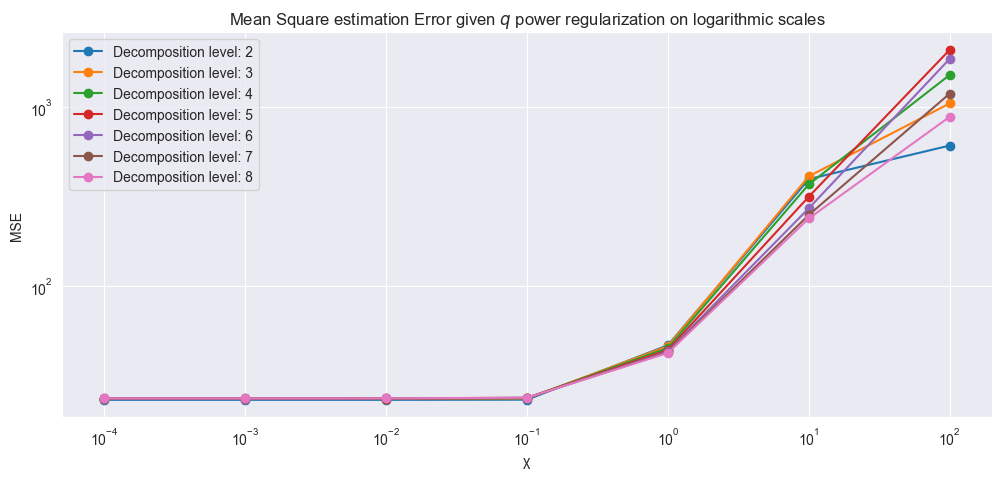

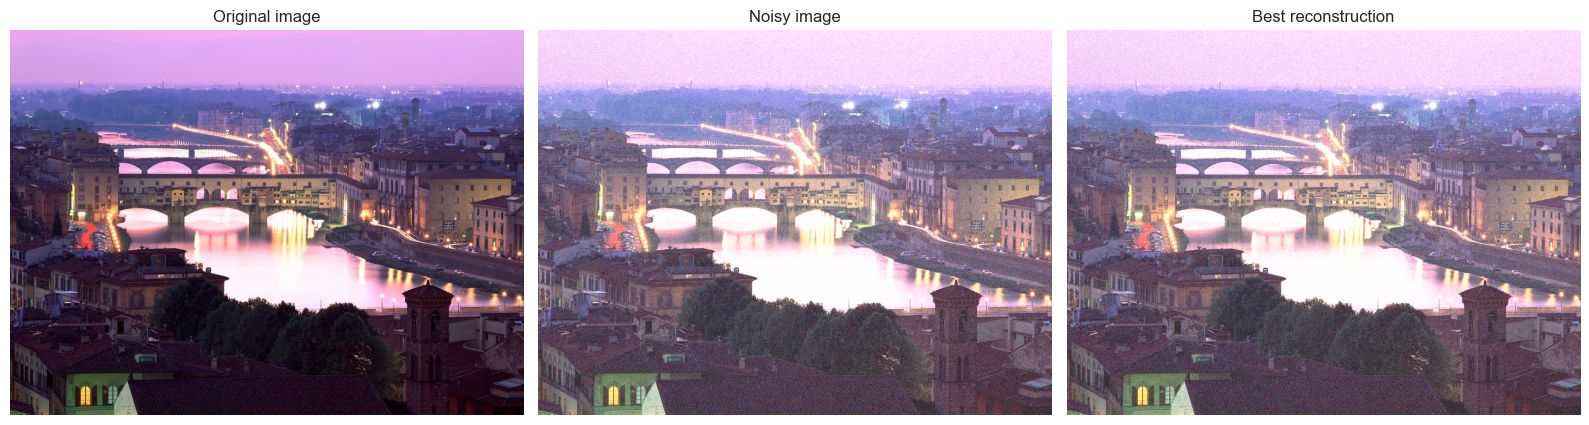

In [43]:
import seaborn as sns
sns.set_style("darkgrid")

# Display best settings       
print("-" * 10)
print("Best settings:")
print(f"decomposition levels: {best_level}")
print(f"q-power: {best_q}")
print(f"χ (regularization): {best_χ}")
print("-" * 10)
print(f"MSE: {best_mse}")

# Display l1 results
fig = plt.figure(figsize=(12, 5))
for level, results in zip(LEVELS, l1_results):
    plt.plot(χ_range, results, label=f"Decomposition level: {level}", linestyle="-", marker="o") 
plt.xlabel("χ")
plt.ylabel("MSE")
plt.title("Mean Square estimation Error given $q$ power regularization on logarithmic scales")
plt.legend(frameon=True)
plt.xscale("log")
plt.yscale("log")
plt.show();

# Display best reconstruction
fig, axes = plt.subplots(1, 3, figsize=(16, 10))
imgs = [x, y, best_z]
titles = ["Original image", "Noisy image", "Best reconstruction"]
for i, tup in enumerate(zip(imgs, titles)):
    img, title = tup
    axes[i].imshow(img)
    axes[i].set_title(title)
    axes[i].set_axis_off()
plt.tight_layout();

In [44]:
def compute_snr(original, approx):
    """
    Signal to Noise Ratio
    
    Parameters
    -------------
    - original : numpy.ndarray (uint8)
        Original image
        
    - approx : numpy.ndarray (uint8)
        Denoising result
        
    Returns
    -------------
    SNR : float
        Signal to Noise Ratio
    """
    # Determine data types
    assert original.dtype == approx.dtype == "uint8",\
            "Expected 'uint8' dtype arrays"
    # Determine shape dimensions
    assert original.shape == approx.shape, "Misaligned shapes" 
    N = shape[0] * shape[1] * shape[2]    
    # Convert to float
    original = original.astype("float32")
    approx = approx.astype("float32")
    # Divide by 255
    original /= 255.
    approx /= 255.
    # Compute SNR
    return 20 * np.log10(np.linalg.norm(original) / np.linalg.norm(original - approx))

In [45]:
print(f"MSE between original and noisy images: {round(compute_snr(y, x), 3)}")
print(f"MSE between original and reconstruction images: {round(compute_snr(y, best_z), 3)}")

MSE between original and noisy images: 10.075
MSE between original and reconstruction images: 47.498


Contrarily to the MSE estimation, here the higher the SNR, the better the reconstruction, by definition.